Balanced Networks
=================



## Notebook Settings



In [1]:
%load_ext autoreload
  %autoreload 2
  %reload_ext autoreload

  %run ../../notebooks/setup.py
  %matplotlib inline
  %config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Imports



In [1]:
import sys
  sys.path.insert(0, '../../')

  import torch
  import pandas as pd
  from time import perf_counter

  from src.network import Network
  from src.lif_network import LIFNetwork
  from src.plot_utils import plot_con
  from src.decode import decode_bump

## Helpers



### Connectivity



In [1]:
def plot_eigen(W):
      # Compute eigenvalues
      eigenvalues = torch.linalg.eigvals(W).cpu().numpy()

      # Extract real and imaginary parts
      real_parts = eigenvalues.real
      imag_parts = eigenvalues.imag

      # Plotting
      plt.scatter(real_parts, imag_parts)
      plt.xlabel('Real Part')
      plt.ylabel('Imaginary Part')
      plt.axhline(y=0, color='k', linestyle='--')
      plt.axvline(x=0, color='k', linestyle='--')

      # plt.grid(True, which='both')
      plt.show()

### Random



In [1]:
def convert_seconds(seconds):
      h = seconds // 3600
      m = (seconds % 3600) // 60
      s = seconds % 60
      return h, m, s

In [1]:
def get_theta(a, b, GM=0, IF_NORM=0):

      if GM:
          b = b - np.dot(b, a) / np.dot(a, a) * a

      if IF_NORM:
          u = a / np.linalg.norm(a)
          v = b / np.linalg.norm(b)
      else:
          u=a
          v=b

      return np.arctan2(v, u)

In [1]:
def normalize(v):
      return v / np.linalg.norm(v)

  def project(x, u):
      return x * u
  # return np.dot(x, u) * u

  def sort_by_angle(x, u, v):
      u_hat = normalize(u)
      v_hat = normalize(v)

      x_proj_u = project(x, u_hat)
      x_proj_v = project(x, v_hat)
      # x_proj = x_proj_u + x_proj_v
      theta = np.arctan2(x_proj_v, x_proj_u) + np.pi

      # cos_theta = np.dot(x_proj, u_hat) / np.linalg.norm(x_proj) * u_hat
      # sin_theta = np.dot(x_proj, v_hat) / np.linalg.norm(x_proj) * v_hat
      # theta = np.arctan2(sin_theta, cos_theta)

      # Pair up each element of x with the corresponding angle
      # x_angle_pairs = list(zip(x, theta))

      # Sort based on the angle
      # x_angle_pairs.sort(key=lambda pair: pair[1])

      # Extract the sorted elements
      # sorted_x = [pair[0] for pair in x_angle_pairs]

      return theta

In [1]:
def get_idx(model):
      ksi = model.PHI0.cpu().detach().numpy()
      print(ksi.shape)

      idx = np.arange(0, len(ksi[0]))
      theta = get_theta(ksi[0], ksi[2], GM=0, IF_NORM=0)

      return theta.argsort()

In [1]:
def get_overlap(model, rates):
      ksi = model.PHI0.cpu().detach().numpy()
      return rates @ ksi.T / rates.shape[-1]

## Single Trial



### Model



In [1]:
REPO_ROOT = "/home/leon/models/NeuroFlame"
  model = Network('config_EI.yml', REPO_ROOT, VERBOSE=0, DEVICE='cuda', TASK='dual', LIVE_FF_UPDATE=1)

### Dynamics



In [1]:
rates = model(RET_FF=1).cpu().detach().numpy()[0]
  print(rates.shape)

(101, 2000)

In [1]:
ff_input = model.ff_input.cpu().numpy()
  print(ff_input.shape)

(1, 101, 2000)

In [1]:
print(np.max(ff_input))
  print(np.mean(ff_input==0))

1377.0
0.0

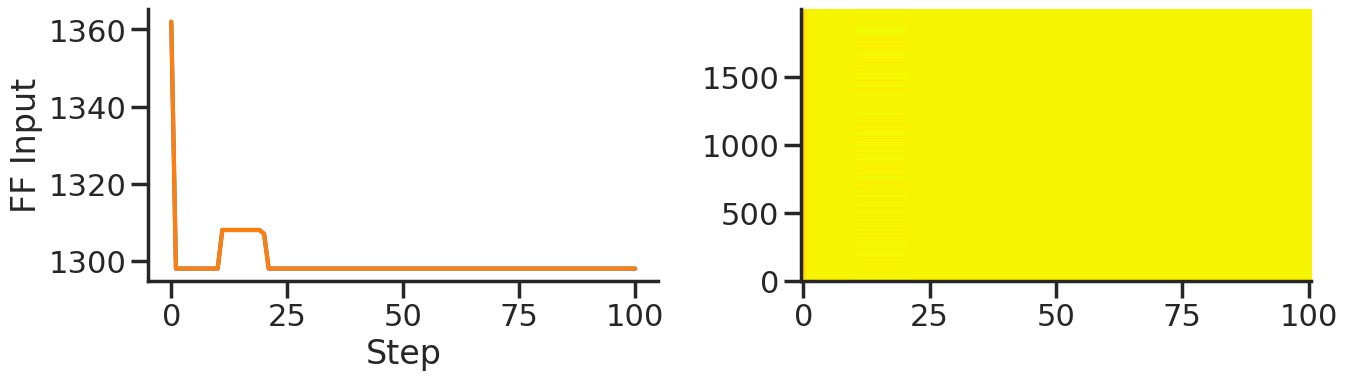

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

  ax[0].plot(ff_input[0, :, 0])
  ax[0].plot(ff_input[0, :, 0])

  ax[0].set_xlabel('Step')
  ax[0].set_ylabel('FF Input')

  ax[1].imshow(ff_input[0].T, aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=2000)
  plt.show()

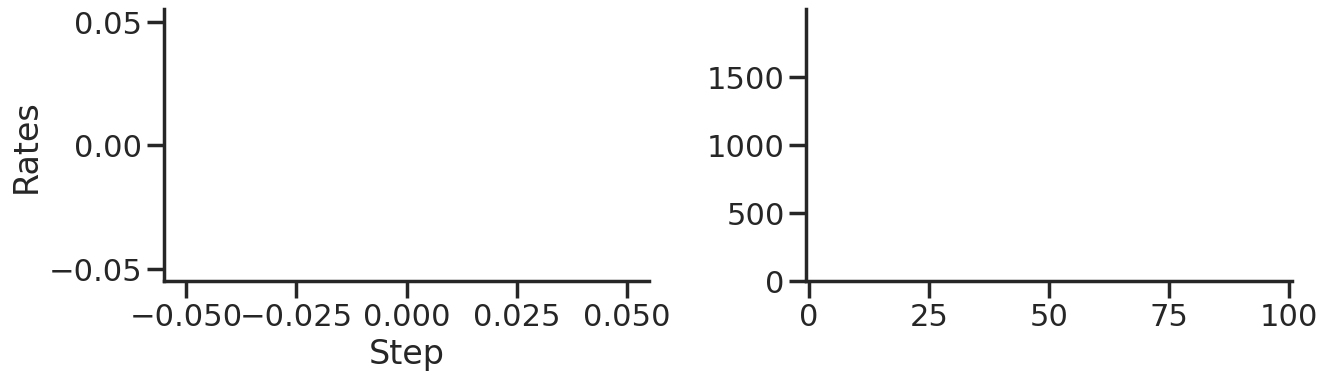

In [1]:
import matplotlib.colors
  # Color for False and True
  cmap = matplotlib.colors.ListedColormap(['blue', 'yellow'])

  r_max = 20

  fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

  ax[0].plot(rates[:, :20])
  ax[0].plot(rates[:, -20:])

  ax[0].set_xlabel('Step')
  ax[0].set_ylabel('Rates')

  ax[1].imshow(rates.T, aspect='auto', origin='lower', cmap='jet')

  # plt.colorbar()
  plt.show()

### Connectivity



(2500, 2500)


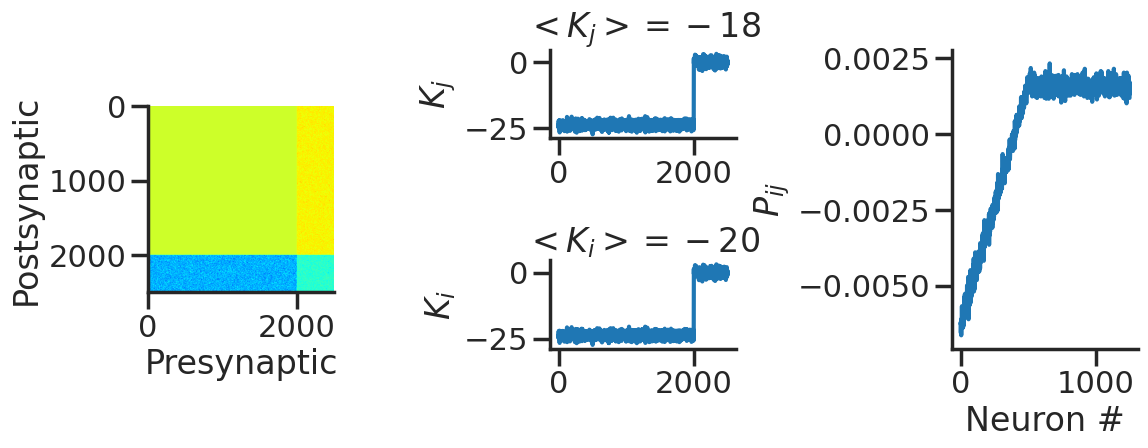

In [1]:
Cij = model.Wab_T.cpu().detach().numpy()
  print(Cij.shape)

  plt.figure(figsize=(12, 5))  # Set the figure size (width, height) in inches

  ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
  im = ax1.imshow(Cij, cmap='jet', aspect=1)
  ax1.set_xlabel("Presynaptic")
  ax1.set_ylabel("Postsynaptic")

  # Second column, first row
  ax2 = plt.subplot2grid((2, 3), (0, 1))
  Kj = np.sum(Cij, axis=0)  # sum over pres
  ax2.set_title('$<K_j>= %d$' % np.mean(Kj))
  ax2.plot(Kj)
  # ax2.set_xticklabels([])
  ax2.set_ylabel("$K_j$")

  # # Second column, second row
  ax3 = plt.subplot2grid((2, 3), (1, 1))
  Ki = np.sum(Cij, axis=1)  # sum over pres
  ax3.set_title('$<K_i>= %d$' % np.mean(Ki))
  ax3.plot(Kj)
  ax3.set_ylabel("$K_i$")

  ax4 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
  diags = []
  for i in range(int(Cij.shape[0] / 2)):
      diags.append(np.trace(Cij, offset=i) / Cij.shape[0])
  diags = np.array(diags)
  ax4.plot(diags)
  ax4.set_xlabel("Neuron #")
  ax4.set_ylabel("$P_{ij}$")

  plt.tight_layout()
  plt.show()

### FF Inputs



(1, 101, 2000)


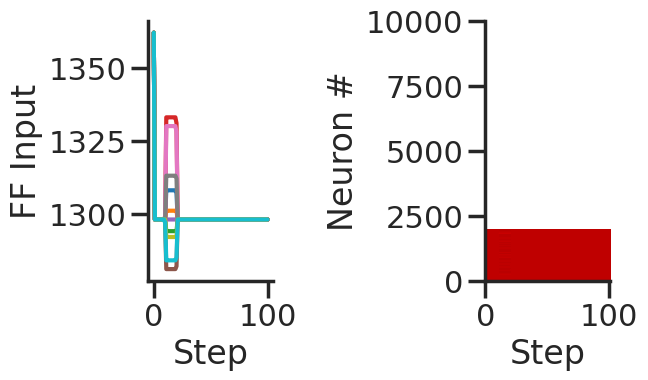

In [1]:
ff_input = model.ff_input.cpu().detach().numpy()
  print(ff_input.shape)

  fig, ax = plt.subplots(1, 2)

  ax[0].plot(ff_input[0, :, :5])
  ax[0].plot(ff_input[0, :, -5:])
  ax[0].set_xlabel('Step')
  ax[0].set_ylabel('FF Input')

  ax[1].imshow(ff_input[0].T, cmap='jet', vmin=0, aspect='auto')
  ax[1].set_xlabel('Step')
  ax[1].set_ylabel('Neuron #')
  ax[1].set_ylim([0, 10000])
  plt.show()

## Balance



In [1]:
REPO_ROOT = "/home/leon/models/NeuroFlame"
  K_list = [500, 1000, 1500, 2000, 2500, 3000]
  rates_list = []

  for K in K_list:
      model = Network('config_2pop.yml', REPO_ROOT, VERBOSE=0, DEVICE='cuda', K=K)
      rates = model.forward()
      rates_list.append(rates[0].cpu().detach().numpy())

(6, 101, 5000)


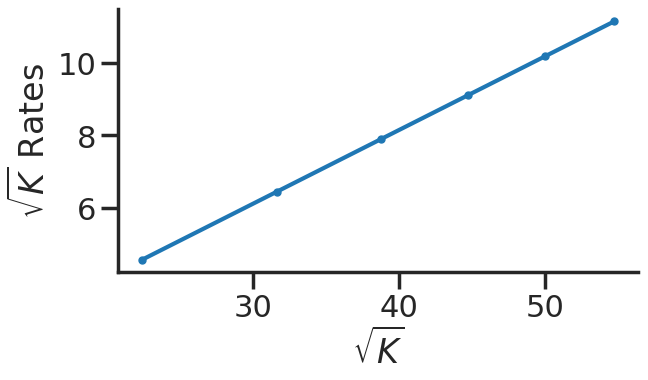

In [1]:
rates = np.array(rates_list)
  print(rates.shape)

  plt.plot(np.sqrt(K_list), np.mean(rates[..., model.slices[0]]) * np.sqrt(K_list), '-o')
  plt.xlabel('$\sqrt{K}$')
  plt.ylabel('$\sqrt{K}$ Rates')
  plt.show()